# Lecture 17: Ensemble learning and random forests

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1SNSqzKBuOnHfK_G_agJQtmE8y3WM2EhI)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2025-02-27 23:21:28


## Ensemble learning overview

- Leverage *wisdom of the crowd*.
- The average from many predictors (or people) may be more accurate that the result from any single given predictor.
- Group of predictors called an *ensemble*.
- Even if individual predictors/classifiers are *weak* (only slightly better than random), an ensemble can be *strong* (high accuracy).

Two broad approaches:
- Different predictors.
- Same predictor, different training sets.

An example of ensemble learning is *Random Forests* where *Decision Trees* are trained on random _*subsets*_ of the training data and then for each sample the assigned class is the one that gets the most *votes* from the ensemble.

## Voting

Consider a number of classifiers.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/votes1.png" alt="data-layout" width="700" style="display:block; margin:auto"/>

[Source: Geron]

### Majority wins (hard voting) 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/votes2.png" alt="data-layout" width="700" style="display:block; margin:auto"/>

[Source: Geron]

*Majorty wins* is often called *hard voting*.

Also _soft_ voting (see upcoming slides and example).

### Example

In [2]:
# Build a voting classifier in Scikit using three weaker classifiers

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# Use moons dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42) #X(features), y(classifications)

# Split into training and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Load three different classification algorithms, and initialise 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

In [3]:
from sklearn.ensemble import VotingClassifier

# Voting classifier "=" logistic + random forest + SVC
# Set up the voting classifier
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')

# Classify using voting classifier (auto uses all the assigned invidiual classifiers)
voting_clf.fit(X_train, y_train);

In [4]:
# Let's see how each individual classifier did:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf): #loop over classifiers
    clf.fit(X_train, y_train) #fit each one individually 
    y_pred = clf.predict(X_test) #make prediction 
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) #print the score    

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896


VotingClassifier 0.92


Voting classifier did better than 3 individual ones!

### Hard vs soft voting

* Hard voting: select class with highest frequency across predictors, without weight taken into account.
* Soft voting: if all classifiers can estimate class probabilities (i.e. they have a `predict_proba()` method), predict overall class probability, averaged over all individual classifiers, and select highest. 

Soft voting is often better than hard voting because it gives more weight to highly confident, but perhaps less frequent, votes.

## Bagging and pasting 

Instead of using different predictors, we can use same the predictor but different training sets. 

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/bagging.png" alt="data-layout" width="700" style="display:block; margin:auto"/>

Two ways to create new training sets: 
- When sampling is performed *with replacement*, this method is called *bagging* (short for bootstrap aggregating).
- When sampling is performed *without replacement*, it is called *pasting*.

A big advantage is that trivially parallisable across nodes/CPU.

### Bagging 

Given a standard training set $D$ of size $n$, **bagging** generates $m$ new training sets $D_{i}$, each of size $n'<n$, by sampling from $D$ uniformly and **with replacement**. 

By sampling *with replacement*, some observations may be repeated in each $D_{i}$.

### Pasting

Given a standard training set $D$ of size $n$, **pasting** generates $m$ new training sets $D_{i}$, each of size $n'<n$, by sampling from $D$ uniformly and **without replacement**. 

By sampling *without replacement*, observations **not** repeated in each $D_{i}$.


### Example

In [5]:
# Example of Decision Trees using moons data from before
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Make a single prediction using a decision tree
tree_clf = DecisionTreeClassifier(random_state=42) #setup classifier
tree_clf.fit(X_train, y_train) #train
y_pred_tree = tree_clf.predict(X_test) #predict
print(accuracy_score(y_test, y_pred_tree)) #test score

0.856


In [6]:
# SciKit Learn provides an easy way to do this using BaggingClassifier 
from sklearn.ensemble import BaggingClassifier #load the bagging classifier 

# Train ensemble of 500 Decision Tree classifiers
# each using 100 training instances - randomly sampled from training set
# with replacement. 

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), #classifier to use
        n_estimators=500, #number of seperate classifiers
        max_samples=100, #number of training instances 
        bootstrap=True, # set to False for pasting instead of bagging.
        n_jobs=1, #number of cores to use -1 is all
        random_state=42)

bag_clf.fit(X_train, y_train) #fit data 
y_pred = bag_clf.predict(X_test) #compare to prediction 
print(accuracy_score(y_test, y_pred))

0.904


Accuracy of bagging increased compared to a single classifier.

#### Plot decision boundary

In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(handle, clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    handle.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        handle.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    handle.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    handle.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    handle.axis(axes)
    handle.set_xlabel(r"$x_1$", fontsize=18)
    handle.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

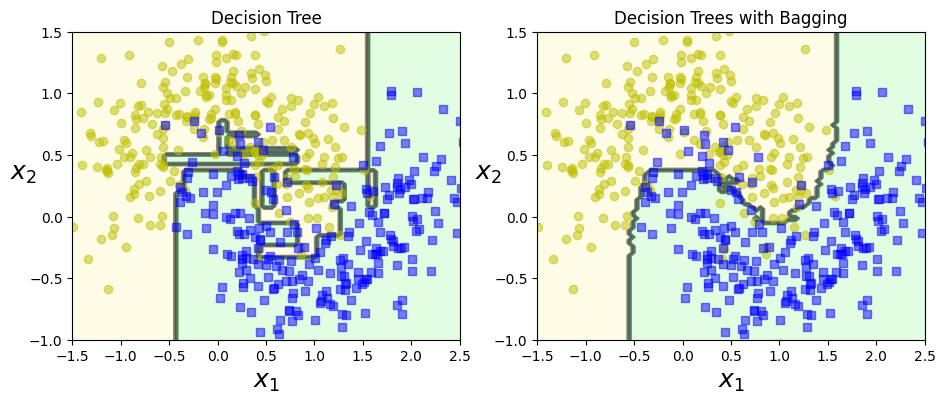

In [8]:
import numpy as np
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

plot_decision_boundary(ax1, tree_clf, X, y), ax1.set_title("Decision Tree")

plot_decision_boundary(ax2, bag_clf, X, y), ax2.set_title("Decision Trees with Bagging");

### Bagging versus pasting

* Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting.
* But this also means that predictors end up being less correlated so the ensemble’s variance is reduced.
* Overall, bagging often results in better models, which explains why it is generally preferred.
* However, if you have spare time and CPU power you can use cross-validation to evaluate both bagging and pasting and select the one that works best.



### Out-of-bag evaluation

* With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 
* By default a ```BaggingClassifier``` samples $m$ training instances with replacement (```bootstrap = True```), where $m$ is the size of the training set.
* Only about ~63% of the training instances are sampled on average for any given predictor.

* The remaining 37% of the training instances that are not sampled are called _out-of-bag (oob) instances_. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it can be used to give a clean evaluation on the oob instances, without the need for a validation set.

In [9]:
# Use oob_score=True in Scikit to do automatic oob evaluation after training.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=1000,
    bootstrap=True, #using replacement 
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

Should expect about 90% accuracy on the test set.  Let's see...

In [10]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.88

## Sampling features

Instead of just sampling training instances, we can also randomly sample the (set of) features themselves.

### Random patches

Sampling *both* instances and features is known as **random patches** method.

In SciKit-Learn this is done by using the `max_features` and `bootstrap_features=True` key words in `BaggingClassifier`.



### Random sub-spaces

Keeping all training instances (i.e., ```bootstrap = False``` and ```max_samples = 1.0```) but sampling features only (i.e., ```bootstrap_features = True``` and/ or ```max_features``` smaller than 1.0) is called the **random subspaces** method.

## Random forests

A random forest is an ensemble of decision trees.

We have actually been manually creating these in the previous examples explicitly!

But we can use built-in SciKit-Learn functionality.
* ```RandomForestClassifier```: specially designed for classification.
* ```RandomForestRegressor```: specially designed for regression.

Typically trained via bagging, although alternatives can be considered.

### Example

Train a random forest directly.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

Equivalane to a bag of decision trees.

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

Check consistent predictions

In [13]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

np.True_

### Extremely randomized trees

When you are growing a tree in a random forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). 

It is possible to make trees even more random by also using *random thresholds* for each feature rather than searching for the *best possible thresholds* (like regular decision trees do).

Implemented using `ExtraTreesClassifier`.

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

rnd_clf = ExtraTreesClassifier(
    n_estimators=500, 
    max_leaf_nodes=16, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_et = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_et))

0.912


### Feature importance

Can measure relative feature importance by looking at how much the tree nodes that use that feature reduce impurity on average.

Specifically, a weighted average is computed, where each node's weight is equal to the number of associated training samples.


Can access using ```feature_importances_``` variable.


In [15]:
# Rank features by importance in iris data (note switching to Iris from Moons)

from sklearn.datasets import load_iris
iris = load_iris()

X=iris["data"]
y=iris["target"]

rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X,y)

# Print out the importances 
for name, importance in zip(iris["feature_names"], rnd_clf.feature_importances_): 
        print(name, "=", importance) 

sepal length (cm) = 0.11249225099876375
sepal width (cm) = 0.02311928828251033
petal length (cm) = 0.4410304643639577
petal width (cm) = 0.4233579963547682


## Boosting

General term to mean combining several weak learners into a single strong learner.

The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available but the most popular are *AdaBoost* (adaptive boosting) and *gradient boosting*. 



### AdaBoost

Give greater weight to training instances that were underfitted in predecessor.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/adaboost.png" alt="data-layout" width="600" style="display:block; margin:auto"/>

[Source: Geron]

AdaBoost pays more attention to training instances that predecessor underfitted, which forces new predictors to concentrate more on the "hard cases".

Disadvantage: results depend on previous classifier (sequential), so algorithm cannot be parallelized. 

### Gradient boosting 

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. 

However, instead of tweaking the instance weights at every iteration like AdaBoost does, gradient boosting tries to fit the new predictor to the *residual error* made by the previous predictor.

### Example

Consider an example using decision trees as the base predictors for a regression problem. This is called Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT).

First, let's implement this by hand.

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# Training set: a noisy quadratic function
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [17]:
# Train Regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y);

In [18]:
# now train 2nd Regressor using errors made by 1st one.
y2 = y - tree_reg1.predict(X) #residual from the first fit (data-prediction)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2);

In [19]:
# now train 3rd Regressor using errors made by 2nd one.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

# now have ensemble w/ three trees.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [20]:
def plot_predictions(
    regressors, X, y, axes,
    ax,
    label=None, 
    style="r-", 
    data_style="b.", 
    data_label=None):
    
    x1 = np.linspace(axes[0], axes[1], 500)
    
    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
            
    ax.plot(X[:, 0], y, data_style, label=data_label)
    ax.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        ax.legend(loc="upper center", fontsize=16)
    ax.axis(axes)

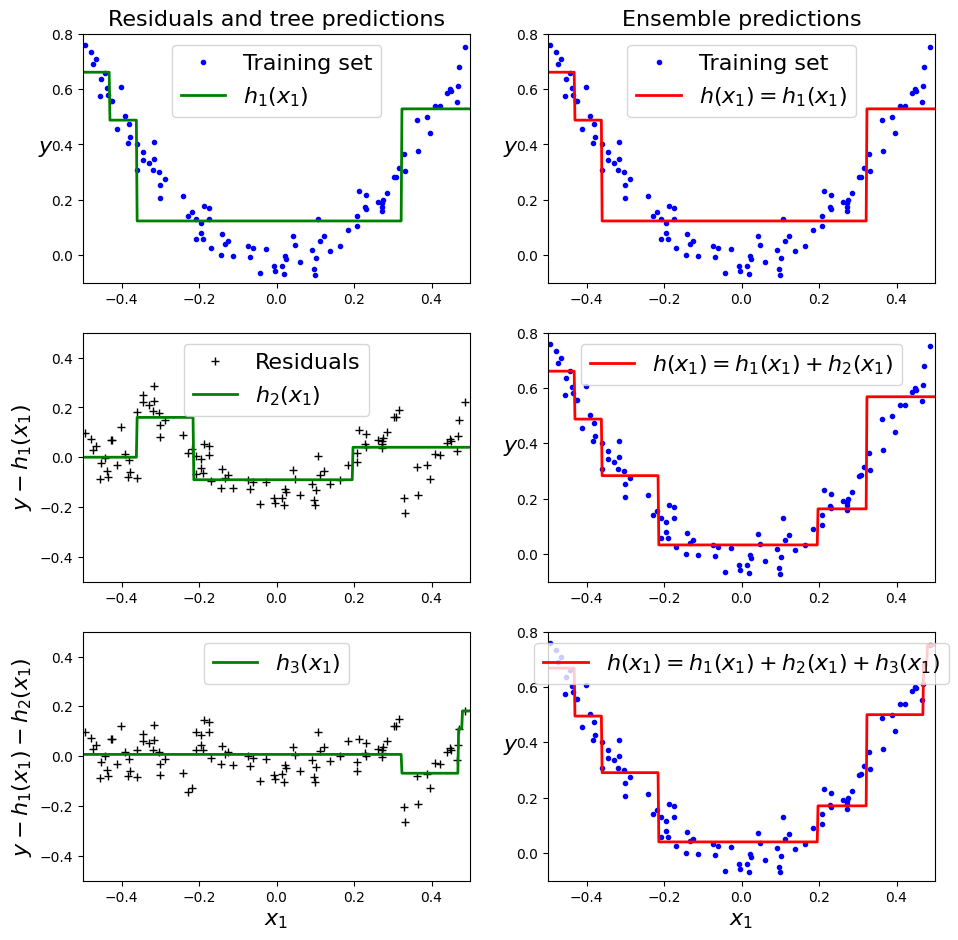

In [21]:
fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize=(11, 11))

plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], ax=ax1, label="$h_1(x_1)$", style="g-", data_label="Training set")
ax1.set_ylabel("$y$", fontsize=16, rotation=0)
ax1.set_title("Residuals and tree predictions", fontsize=16)

plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], ax=ax2, label="$h(x_1) = h_1(x_1)$", data_label="Training set")
ax2.set_ylabel("$y$", fontsize=16, rotation=0)
ax2.set_title("Ensemble predictions", fontsize=16)

plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], ax=ax3, label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
ax3.set_ylabel("$y - h_1(x_1)$", fontsize=16)

plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], ax=ax4, label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
ax4.set_ylabel("$y$", fontsize=16, rotation=0)

plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], ax=ax5, label="$h_3(x_1)$", style="g-", data_style="k+")
ax5.set_ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
ax5.set_xlabel("$x_1$", fontsize=16)

plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], ax=ax6, label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
ax6.set_xlabel("$x_1$", fontsize=16)
ax6.set_ylabel("$y$", fontsize=16, rotation=0);

The ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. 

You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.



Now, let's use in-built functionality rather than implementing by hand.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

For GBRT, the learning rate plays the role of scaling the contribution for each tree.

Low values (e.g. 0.1) need more trees in ensemble to fit training set but predictions usually generalize better. This is called shrinkage.

Can also consider early stopping to regularise.

In [23]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, # Early stopping (set to None to turn off)
    random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [24]:
gbrt_best.n_estimators_

92

In [25]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

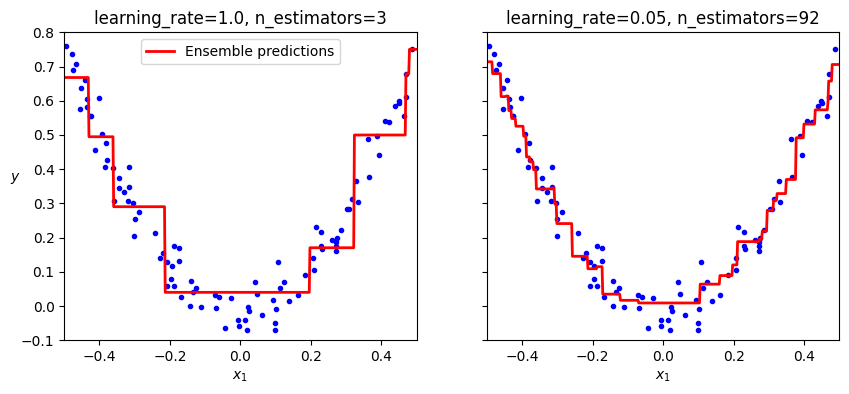

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$");
plt.ylabel("$y$", rotation=0);

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$");

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

## Stacking (or meta learning)

Stacking (stacked generalisation) introduces a learner to find the optimal combination, rather than a simple aggregation.

Done by a _blender_ or _meta learner_.


<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/blender.png" alt="data-layout" width="600" style="display:block; margin:auto"/>

[Source: Geron]

Can extend to multiple blenders.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/blender2.png" alt="data-layout" width="600" style="display:block; margin:auto"/>

[Source: Geron]